In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cohlib.utils import pickle_open, logistic
from cohlib.plot import draw_raster_single
from cohlib.alg.em_sgc import deconstruct_Gamma_full_real
from cohlib.utils import conv_v_to_z, conv_z_to_v

In [17]:
import jax.numpy as jnp
import jax.random as jr
rk = jr.key(7)
A = jr.normal(rk, (3,3))
Ainv = jnp.linalg.inv(A)
B = 0.5*A.copy()
Binv = jnp.linalg.inv(B)


In [4]:
def get_power1(Gamma):
    return Gamma[:,0,0].real

def get_power1dB(Gamma):
    return 10*np.log10(Gamma[:,0,0].real)


def Gamma_est_from_zs(zs, dc=True):
    if dc is True:
        zs_outer = np.einsum('ijk,imk->kjmi', zs[:,:,1:], zs[:,:,1:].conj())
    else:
        zs_outer = np.einsum('ijk,imk->kjmi', zs, zs.conj())
    zs_outer_mean = zs_outer.mean(3)
    return zs_outer_mean

In [5]:
mu = 0.0
K = 2
L = 25 
C = 1
sample_length = 1000
seed = 7
ov1 = 1.0


In [84]:
import os
import jax.numpy as jnp
import jax.random as jr
from cohlib.utils import gamma_root
from cohlib.jax.dists import sample_from_gamma
from cohlib.jax.observations import add0


lseed = 7
oseed = 7
flow = 1
fhigh = 50
sp_target = 5
sp_offtarget = 1
gamma_path = os.path.join(gamma_root(), f"k2-full{flow}-{fhigh}-10-{sp_target}-{sp_offtarget}.pickle")
gamma_load = pickle_open(gamma_path)

gamma_full = gamma_load['gamma']
freqs = gamma_load['freqs']
N = freqs.size
nz = gamma_load['nonzero_inds']
nz_target = jnp.array([9])
K = gamma_full.shape[-1]


In [85]:
ov2 = -1.0



seed = 8
etype="approx"
model_path = f'saved/fitted_models/jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
model_load = pickle_open(model_path)

Wv_model = model_load['Wv']
Wv = Wv_model
num_J_vars = Wv.shape[1]
freqs_mod = freqs[:int((Wv.shape[1]) / 2)]

J_max = int((Wv.shape[1])/2)


In [88]:
lseed = 7
lrk = jr.key(lseed)

zs = sample_from_gamma(lrk, gamma_full, L)
zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)

zs0 = zs[nz,0,:]
vs0 = conv_z_to_v(zs0, axis=0)


xs_old = Wv @ vs0
xs_old.shape

J = 500
Wv_mod = Wv * (1 / (2 * np.pi))
xs_old_mod = Wv_mod @ vs0

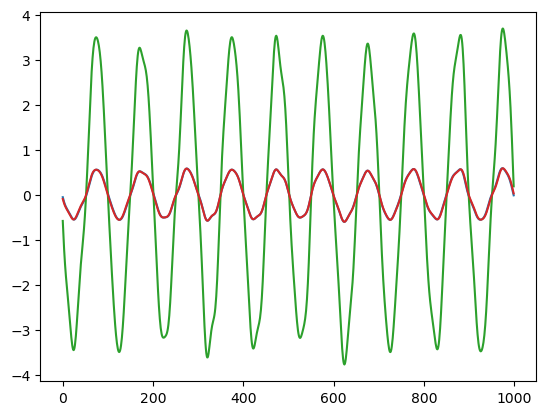

In [89]:
for i in range(1):
    plt.plot(xs[:,0,i], color='tab:blue')
    plt.plot(xs_old[:,i], color='tab:green')
    plt.plot(xs_old_mod[:,i], color='tab:red')

In [108]:
num_samples = 500
fft_samples = jnp.zeros((nz.size, num_samples), dtype=complex)
wv_samples = jnp.zeros((nz.size, num_samples), dtype=complex)
lseed = 7
for lseed in range(num_samples):
    lrk = jr.key(lseed)

    zs = sample_from_gamma(lrk, gamma_full, L)
    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)

    zs0 = zs[nz,0,:]
    vs0 = conv_z_to_v(zs0, axis=0)


    xs_old = Wv @ vs0
    xs_old.shape

    J = 500
    Wv_mod = Wv * (1 / (2 * np.pi))
    xs_old_mod = Wv_mod @ vs0

    vs_wv = Wv_mod.T @ (xs[:,0,i] - xs[:,0,i].mean(0)) 
    zs_wv = conv_v_to_z(vs_wv, axis=0)

    zs_fft = jnp.fft.rfft(xs[:,0,i] - xs[:,0,i].mean(0))[1:51]

    wv_samples = wv_samples.at[:,lseed].set(zs_wv)
    fft_samples = fft_samples.at[:,lseed].set(zs_fft)



    # lim = 20

    # plt.plot(zs_fft.real, zs_wv.real*500, '.')
    # plt.plot(zs_fft.imag, zs_wv.imag*500, '.')
    # plt.xlabel(r'rfft($x$)')
    # plt.ylabel(r'$W^{\top}x$')
    # plt.xlim([-lim,lim])
    # plt.ylim([-lim,lim])
    # plt.axline(jnp.array([0,0]), slope=1)
    # plt.show()

This is weird... why is there randomly an additive shift sometimes? 

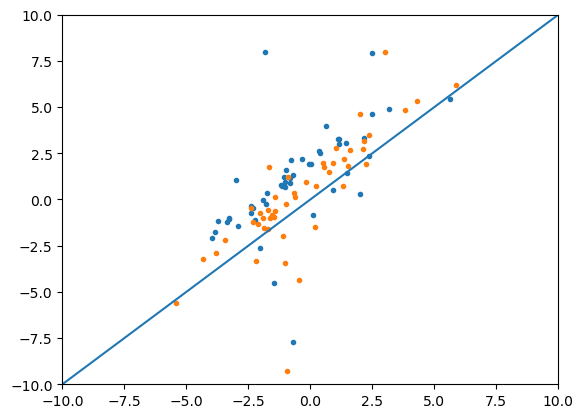

In [107]:
l = 0
lim = 10
j = 3
scale = 500
# plt.plot(fft_samples[j,:].real, scale*wv_samples[j,:].real, '.')
# plt.plot(fft_samples[j,:].imag, scale*wv_samples[j,:].imag, '.')
plt.plot(fft_samples[:,l].real, scale*wv_samples[:,l].real, '.')
plt.plot(fft_samples[:,l].imag, scale*wv_samples[:,l].imag, '.')
plt.xlim([-lim,lim])
plt.ylim([-lim,lim])
plt.axline([0,0], slope=1)

In [81]:
zs_wv[:5]

array([ 0.00213162-0.00222951j, -0.00153741+0.00199914j,
       -0.00830975-0.00450322j,  0.00442834-0.00209892j,
       -0.00350672+0.00969215j], dtype=complex64)

In [82]:
print(zs_fft[:5])
print(zs_fft[:5])

[ 1.071779  -1.2253928j -0.75375605+0.7805705j -4.1759605 -2.6121416j
  2.194222  -1.6136209j -1.7635887 +4.131817j ]
[ 1.071779  -1.2253928j -0.75375605+0.7805705j -4.1759605 -2.6121416j
  2.194222  -1.6136209j -1.7635887 +4.131817j ]


... so off by 3 orders of magnitude

Is there any way in which this is compensated? 

Next - compare zs_fft to zs_wv visually 

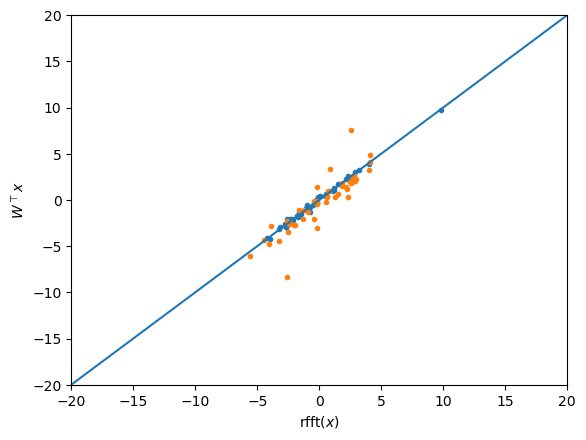

In [83]:
lim = 20

plt.plot(zs_fft.real, zs_wv.real*500, '.')
plt.plot(zs_fft.imag, zs_wv.imag*500, '.')
plt.xlabel(r'rfft($x$)')
plt.ylabel(r'$W^{\top}x$')
plt.xlim([-lim,lim])
plt.ylim([-lim,lim])
plt.axline(jnp.array([0,0]), slope=1)